**Exploratory Data Analysis and Graph generation**

Many thanks to Laura Fink and her EDA notebooks which can be found [here](https://www.kaggle.com/allunia/rsna-ih-detection-eda)

*Abdullah Hasan*

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
from PIL import Image
import os
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()


CSV file is read in here and transformed for processing later.

Additional columns are generated to make later operations easier

In [2]:
BASE_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
TRAIN_DIR = "stage_2_train/"

train_df = pd.read_csv(BASE_PATH + 'stage_2_train.csv')
train_df['filename'] = train_df['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
train_df['type'] = train_df['ID'].apply(lambda st: st.split('_')[2])
train_df['id'] = train_df['ID'].apply(lambda st: st.split('_')[1])



**Label distribution plot**

Text(0.5, 1.0, 'Label distribution')

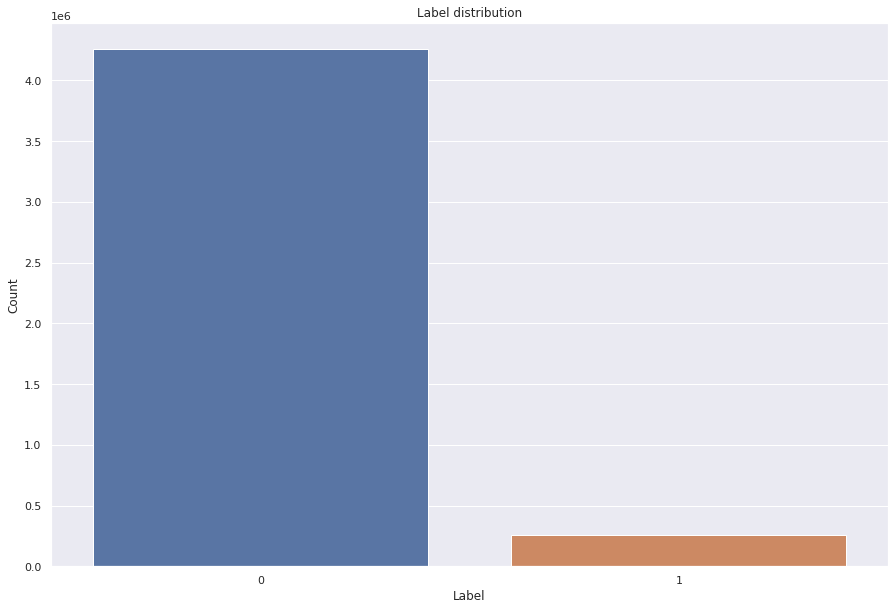

In [3]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(train_df.Label,ax=ax)
ax.set_xlabel("Label")
ax.set_ylabel("Count")
ax.set_title("Label distribution")

**Type distribution plot**

Text(0.5, 1.0, 'Type distribution')

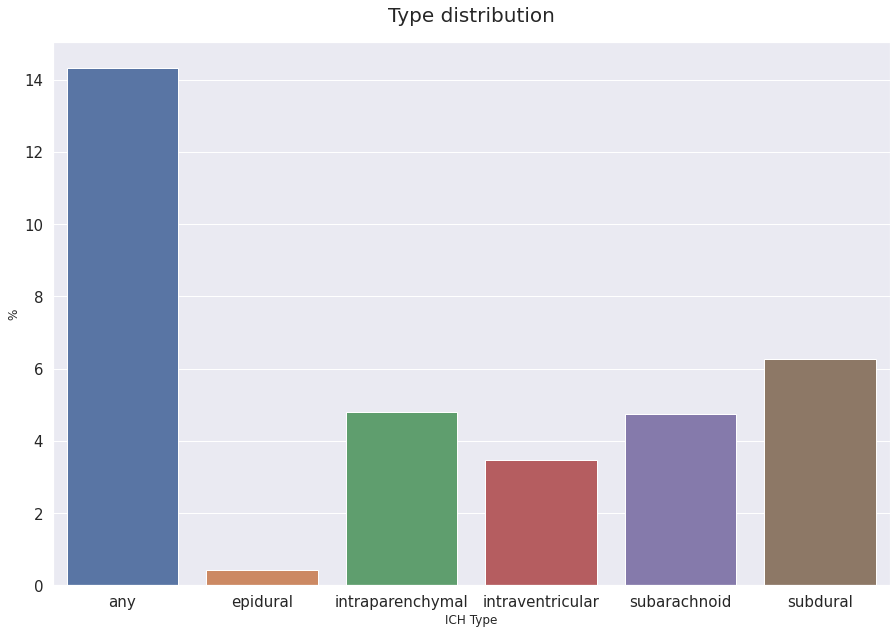

In [4]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
type_counts = train_df.groupby("type").Label.value_counts().unstack()
true_cases = type_counts.loc[:,1] / train_df.groupby("type").size() * 100
sns.barplot(x=true_cases.index,y=true_cases.values,ax=ax)
plt.yticks(rotation=0,size=15)
plt.xticks(rotation=0,size=15)
ax.set_xlabel("ICH Type")
ax.set_ylabel("%")
ax.set_title("Type distribution",pad=20)

**Label co-occurence plot**

Text(0, 0.5, 'Frequency')

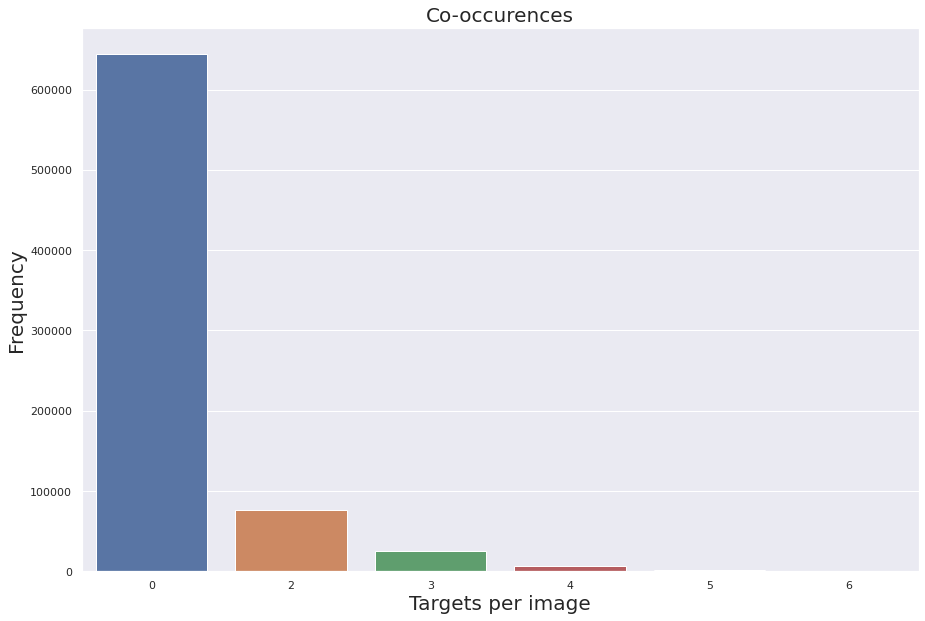

In [5]:
fig, ax = plt.subplots(figsize=(15, 10))
multi_count = train_df.groupby("id").Label.sum()
sns.countplot(multi_count,ax=ax)
ax.set_title("Co-occurences")
ax.set_xlabel("Targets per image")
ax.set_ylabel("Frequency")

**Label co-occurence matrix**

In [6]:
df = train_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()

In [7]:
df[df['any']==1]['any'].count()

107933

In [8]:
df[df['any']==0]['any'].count()

644870

In [9]:
df.count()

type
filename            752803
any                 752803
epidural            752803
intraparenchymal    752803
intraventricular    752803
subarachnoid        752803
subdural            752803
dtype: int64

In [10]:

cols = ['epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
labels = df[cols]
output = pd.DataFrame(
{x:[(df[x] & df[y]).sum() for y in cols] for x in cols},
index=cols)
output


,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
epidural,3145,642,227,569,724
intraparenchymal,642,36118,10499,9155,7295
intraventricular,227,10499,26205,7572,3740
subarachnoid,569,9155,7572,35675,9332
subdural,724,7295,3740,9332,47166


**Co-occurence matrix plot**

In [11]:
#output
output["epidural"][output["epidural"].index != "epidural"].sum()

2162

In [12]:
normalized_df = output.copy().astype(np.float32)
for col in cols:
    total = output[col][col]
    total_col = total - output[col][output[col].index != col].sum()
    normalized_df[col][col] = total_col / total
    for other in cols:
        if other == col:
            continue
        normalized_df[col][other] = output[col][other] / total
normalized_df

,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
epidural,0.312560,0.017775,0.008662,0.015950,0.015350
intraparenchymal,0.204134,0.236087,0.400649,0.256622,0.154666
intraventricular,0.072178,0.290686,0.159015,0.212249,0.079294
subarachnoid,0.180922,0.253475,0.288952,0.253595,0.197854
subdural,0.230207,0.201977,0.142721,0.261584,0.552835


In [13]:
sum(normalized_df['epidural'])

0.9999999925494194

In [14]:
normalized_df = normalized_df.rename({
    "epidural":"EDH",
    "intraparenchymal":"IPH",
    "intraventricular":"IVH",
    "subarachnoid":"SAH",
    "subdural":"SDH"
},axis="index")
normalized_df = normalized_df.rename(index=str,columns={
    "epidural":"EDH",
    "intraparenchymal":"IPH",
    "intraventricular":"IVH",
    "subarachnoid":"SAH",
    "subdural":"SDH"
})

Text(0.5, 1.0, 'Co-occurring haemorrhages matrix')

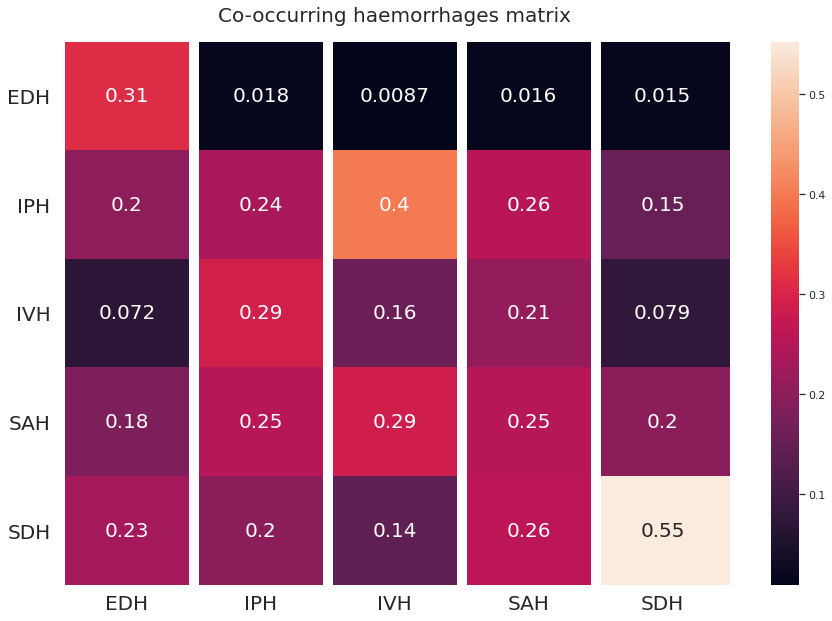

In [15]:
plt.rcParams['axes.labelsize'] = 40
plt.rcParams['axes.titlesize'] = 20
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(normalized_df,ax=ax,annot=True,annot_kws={"size": 20})
for i in np.arange(0,5,1.0):
    ax.axvline(i, color='white', lw=10)
plt.yticks(rotation=0,size=20)
plt.xticks(rotation=0,size=20)
ax.set_title("Co-occurring haemorrhages matrix",pad=20)
#ax.set_title("Co-occurence Matrix")

In [16]:
ax.get_xticks()

array([0.5, 1.5, 2.5, 3.5, 4.5])

In [17]:
#for i in range(type_list):
#    title = cols[i]
#    dataset = type_list[i]
#    fig,ax = plt.subplots()
#    sns.countplot(dataset,ax=ax)
#    plt.show()